# Model training and predictions 
### Read from file and data cleaning

In [1]:
from pyspark.sql import SparkSession
spark  = SparkSession.builder.appName('App').config("spark.driver.memory", "14g").getOrCreate()

In [2]:
print(spark.sparkContext._conf.getAll())

[('spark.rdd.compress', 'True'), ('spark.app.name', 'App'), ('spark.serializer.objectStreamReset', '100'), ('spark.driver.port', '54071'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.executor.id', 'driver'), ('spark.submit.deployMode', 'client'), ('spark.app.id', 'local-1607815439594'), ('spark.driver.memory', '14g'), ('spark.driver.host', 'kailundembp.hitronhub.home'), ('spark.ui.showConsoleProgress', 'true')]


In [3]:
""" NOTE: If prepared data exists, load it here: 
"""

# test_df = spark.read.parquet("test_df")
# test_df = test_df.repartition(16)
# train_df = spark.read.parquet("train_df")
# train_df = train_df.repartition(16)

' NOTE: If prepared data exists, load it here: \n'

In [4]:
# File location and type
file_location = "sample_train2 (1).csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","
multiline = "true"
escape = "\""

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.csv(file_location,
                  inferSchema = infer_schema, 
                  sep = delimiter, 
                  header = first_row_is_header, 
                  multiLine = multiline, 
                  escape = escape)
df = df.repartition(16)

In [5]:
df.show()

+-----+--------------------+--------------------+-------------------+
|  _c0|                Body|               Title|                tag|
+-----+--------------------+--------------------+-------------------+
|53817|<p>I can use Serv...|How can I update ...|             apache|
| 3423|<p>I have a GridV...|How to change in ...|           gridview|
|43911|<p>I'm struggling...|UIPickerView sele...|          core-data|
|52872|<p>Is there a way...|How can I find ou...|wireless-networking|
|12734|<p><a href="http:...|How to Removing f...|          functions|
|53749|<p>I need to supp...|Mod Auth CAS Two ...|     authentication|
|76673|<p>Disclaimer: I'...|Reload Current Pa...|         javascript|
|77443|<p>At the request...|HP iLO Wildcard S...|                ssl|
|  137|<p>Suppose I have...|Can I return the ...|             lucene|
|60665|<p>I need to get ...|JQPlot Basic Char...|             jquery|
|52822|<p>can someone co...|Please confirm ch...|           .net-4.0|
| 8792|<p>I have an 

### Indexing tags in both test and train data sets

In [6]:
from pyspark.ml.feature import StringIndexer

#Encode tag's using String indexer

tag_idx = StringIndexer(inputCol='tag', outputCol = 'tag_idx')
tag_encode = tag_idx.fit(df)
df = tag_encode.transform(df)

In [7]:
df.count()

100118

### Split test/train sets

In [8]:
TRAINING_DATA_RATIO = 0.9
RANDOM_SEED = 1234

splits = [TRAINING_DATA_RATIO, 1.0 - TRAINING_DATA_RATIO]
training_data, test_data = df.randomSplit(splits, RANDOM_SEED)

In [9]:
print("Number of training set rows: %d" % training_data.count())
print("Number of test set rows: %d" % test_data.count())

Number of training set rows: 90163
Number of test set rows: 9955


# Preprocessing 

In [10]:
from bs4 import BeautifulSoup
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_en = stopwords.words('english')
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import RegexTokenizer

""" Helper functions for preprocessing. TODO: Consider wrapping into class below?
"""

@udf("String")
def lazy_prep_udf(c):
  """
  Clean noises from the string of text in given column

  Args:
    c - Column containing string of text

  Returns:
    Column with the cleaned string of text
  """
  df = BeautifulSoup(c)
  
  #noise
  urls = df.find_all('a')
  if urls != None:
    if len(urls)>0: 
      df.a.clear()
  
  return df.get_text().lower()

def tokenize(df, inputCol, outputCol):
  """
Split string of text in dataframe to word tokens.

Args:
  @param df Dataframe containing string of text
  @param inputCol name of input column containin the string of texts
  @param outputCol name of output column containin the word tokens
  
Returns:
  Dataframe containing the output column and the input column is dropped
"""
  tokenizer = RegexTokenizer(inputCol = inputCol, outputCol = outputCol, pattern=r"\s+") 
  df = tokenizer.transform(df).drop(inputCol)
  return df

def remove_punc(text):
  """Removes all punctuation marks from text.
  Args: 
    text (String): text column to convert 
  Returns:
    String.sql.Row: text w.o punctuation 
  """
  mod_punc = '!"$%&\'()*,-./:;<=>?@[\\]^_`{|}~'
  text = text.translate(str.maketrans(' ', ' ', mod_punc))
  return text.strip()


def remove_num(text):
  """Removes all numbers from text.
  Args: 
    text (String): text column to convert 
  Returns:
    String: text w.o numbers 
  """
  numbers="0123456789"
  text = text.translate(str.maketrans(' ', ' ', numbers))
  return text.strip()


  from nltk.tokenize import RegexpTokenizer 

@udf("String")
def trad_prep_udf(body):
  """Traditional body text preprocessing pieline. 
  Args: 
    text (pyspark.sql.Row): Text String to process
  Returns: 
    pyspark.sql.Row.ArrayType: cleaned tokens 
  """
  body = BeautifulSoup(body)
  stemmer = PorterStemmer()
  
  #noise
  urls = body.find_all('a')
  if len(urls)>0: 
    body.a.clear()
  
  text = body.get_text()
  
  words = []
  text = text.lower()

  tokenizer = RegexpTokenizer(r'\w+')
  # text = remove_punc(text)
  # text = remove_num(text)
  sents=tokenizer.tokenize(text)
  for sent in sents: 
    for word in nltk.word_tokenize(sent):
      if word in stop_en: continue
      # if len(word) < 3: continue
      words.append(stemmer.stem(word))
  return " ".join(words)


  """
Combine word tokens from title and body.

Args:
  df1 Dataframe containing Column with lists of stemmed word tokens from title
  inputCol1 name of the column containing lists of stemmed word tokens from title, cannot be same as inputCol2
  df2 Dataframe containing Column with lists of stemmed word tokens from body
  inputCol2 name of the column containing lists of stemmed word tokens from body, cannot be same as inputCol2
  outputCol column name of the ouput column containing the combined list of word tokens from title and body
"""
def combine_tokens(df, inputCol1, inputCol2, outputCol):
  result = df.withColumn(outputCol, concat(col(inputCol1), col(inputCol2)))
  return result

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kailunzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kailunzhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
class Preprocessing:
  """Preprocessing stackoverflow question by remove html tags and tokenize words"""
  
  def __init__(self, df, titleCol, bodyCol):
    """
    Construct a Proprocessing object with attribute df: df cleans the text string in the given df using either lazy or traditional preprocessing
    """
    df = df.withColumn("Lazy_Title", lazy_prep_udf( df[titleCol] ) )
    df = df.withColumn("Lazy_Body", lazy_prep_udf( df[bodyCol] ) )
    df = df.withColumn("Trad_Title", trad_prep_udf( df[titleCol] ) )
    self.df = df.withColumn("Trad_Body", trad_prep_udf( df[bodyCol] ) )

  def get_token(self):
    self.df = tokenize(self.df, "Lazy_Title", 'Lazy_Title_Tokens')
    self.df = tokenize(self.df, "Lazy_Body", 'Lazy_Body_Tokens')
    self.df = tokenize(self.df, "Trad_Title", 'Trad_Title_Tokens')
    self.df = tokenize(self.df, "Trad_Body", 'Trad_Body_Tokens')
    return self.df

In [12]:
#Pre-processing the data
preProcessing = Preprocessing(df, "Title", "Body")
df_data = preProcessing.get_token()

In [13]:
from pyspark.sql.functions import desc, col

tag_counts = df.select('tag').groupby('tag').count().sort(desc('count'))
tag_counts.sort(col('count').desc()).show()

+-----------+-----+
|        tag|count|
+-----------+-----+
|     jquery| 3841|
|       .net| 2617|
|      mysql| 2364|
|    asp.net| 2021|
|       html| 1964|
|        css| 1786|
|objective-c| 1756|
|        ios| 1683|
|    android| 1478|
| javascript| 1196|
|      regex| 1109|
|     arrays| 1102|
|        xml| 1093|
|        sql| 1014|
|       ruby|  954|
| sql-server|  912|
|       ajax|  800|
|        wpf|  772|
|   database|  769|
|    windows|  765|
+-----------+-----+
only showing top 20 rows



In [14]:
body_counts = df_data.select('Trad_Body_Tokens').rdd.flatMap(lambda l : [(w,1) for w in l.Trad_Body_Tokens]).reduceByKey(lambda a,b: a+b).collect()
body_counts.sort(key=lambda tup: -tup[1])

In [15]:
display(body_counts[:10])

[('0', 102730),
 ('use', 95802),
 ('1', 95336),
 ('new', 57867),
 ('class', 56422),
 ('get', 56200),
 ('file', 54214),
 ('id', 53403),
 ('2', 51670),
 ('name', 51301)]

In [16]:
title_counts = df_data.select('Trad_Title_Tokens').rdd.flatMap(lambda l : [(w,1) for w in l.Trad_Title_Tokens]).reduceByKey(lambda a,b: a+b).collect()
title_counts.sort(key=lambda tup: -tup[1])

In [17]:
display(title_counts[:10])

[('use', 10112),
 ('file', 5646),
 ('c', 5221),
 ('get', 4457),
 ('jqueri', 4223),
 ('php', 4106),
 ('net', 3420),
 ('data', 3370),
 ('error', 3265),
 ('valu', 3223)]

In [18]:
#Pre-processing the data
preProcessing = Preprocessing(test_data, "Title", "Body")
test_data = preProcessing.get_token()
preProcessing = Preprocessing(training_data, "Title", "Body")
training_data = preProcessing.get_token()


# Machine Learning Data Preparation

### Feature Engineering

In [19]:
from pyspark.ml.feature import CountVectorizer, IDF, NGram, VectorAssembler, StringIndexer, HashingTF
from pyspark.ml import Pipeline
def feature_engineer():
# FOR LAZY PRE-PROCESSING
  lazy_body_vector = CountVectorizer(inputCol = 'Lazy_Body_Tokens', outputCol = 'lazy_body_vector', minDF=0.01 , maxDF=0.85)
  lazy_title_vector = CountVectorizer(inputCol = 'Lazy_Title_Tokens', outputCol = 'lazy_title_vector', minDF=0.01 , maxDF=0.85)
  # FOR TRAD PRE-PROCESSING
  trad_body_vector = CountVectorizer(inputCol = 'Trad_Body_Tokens', outputCol = 'trad_body_vector', minDF=0.01 , maxDF=0.99)
  trad_title_vector = CountVectorizer(inputCol = 'Trad_Title_Tokens', outputCol = 'trad_title_vector', minDF=0.01 , maxDF=0.99)

  lazy_features = VectorAssembler(inputCols=['lazy_body_vector', 'lazy_title_vector'], outputCol='lazy_features')
  trad_features = VectorAssembler(inputCols=['trad_body_vector', 'trad_title_vector'], outputCol='trad_features')
  pipe = Pipeline(stages=[lazy_body_vector, lazy_title_vector, lazy_features, trad_body_vector, trad_title_vector, trad_features])
  pipe_model = pipe.fit(training_data)
  train_df = pipe_model.transform(training_data)  
  test_df = pipe_model.transform(test_data)
  return train_df, test_df

In [20]:
train_df, test_df = feature_engineer()

In [21]:
test_df.select("Trad_Body_Tokens", "trad_features", 'Body').show()

+--------------------+--------------------+--------------------+
|    Trad_Body_Tokens|       trad_features|                Body|
+--------------------+--------------------+--------------------+
|[pleas, help, for...|(1004,[7,8,22,32,...|<p>Please help me...|
|[fairli, new, ope...|(1004,[1,3,13,15,...|<p>I'm fairly new...|
|[visual, studio, ...|(1004,[0,1,2,3,4,...|<p>My Visual Stud...|
|[test, bandwidth,...|(1004,[13,17,36,6...|<p>To test bandwi...|
|[tri, debug, ie, ...|(1004,[6,15,21,45...|<p>I'm trying to ...|
|[wrote, page, cal...|(1004,[3,5,10,14,...|<p>I wrote a page...|
|[switch, tf, svn,...|(1004,[1,3,6,34,3...|<p>We just switch...|
|[print, 2, argume...|(1004,[2,9,14,16,...|<p>I can print mo...|
|[site, need, acce...|(1004,[1,13,21,30...|<p>The site needs...|
|[face, problem, s...|(1004,[1,14,26,34...|<p>I am facing a ...|
|[could, join, mul...|(1004,[0,44,47,74...|<p>How could i jo...|
|[want, use, ssi, ...|(1004,[1,5,17,21,...|<p>I want to use ...|
|[iphon, app, need...|(10

# Model Training

## Metrics helper

In [22]:
from pyspark.mllib.evaluation import MulticlassMetrics


def print_metrics(results_df, by_tag = False, ground_truth_col='tag_idx', prediction_col='prediction'):
    labels_and_predictions = results_df.select([ground_truth_col, prediction_col])
    # Instantiate metrics object
    metrics = MulticlassMetrics(labels_and_predictions.rdd)
    # Overall statistics
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1Score = metrics.fMeasure(1.0)
    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)
    # Weighted stats
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

    if by_tag: 
        # Statistics by class
        labels = df.rdd.map(lambda lp: lp.tag_idx).distinct().collect()
        # print(labels)
        for label in sorted(labels):
            try:
                print("Class %s precision = %s" % (label, metrics.precision(label)))
                print("Class %s recall = %s" % (label, metrics.recall(label)))
                print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
            except: 
                print("Class %s not in this set!" % (label))

## Logistic Regression

**Hyperparameter Tuning**

**Model training and transformation of test set**

In [24]:
from pyspark.ml.classification import LogisticRegression
# Trad model
lr_trad = LogisticRegression(featuresCol = "trad_features", labelCol = "tag_idx", fitIntercept=True, elasticNetParam=0.0, regParam=0.0)
lr_trad_model = lr_trad.fit(train_df)
lr_trad_results = lr_trad_model.transform(test_df)

**Performance Metrics**

In [25]:
# Trad Metrics
#lr_trad = LogisticRegression(featuresCol = "trad_features", labelCol = "tag_idx", fitIntercept=False, elasticNetParam=0.0, regParam=0)
print_metrics(lr_trad_results)

Summary Stats
Precision = 0.1722689075630252
Recall = 0.14487632508833923
F1 Score = 0.15738963531669867
Weighted recall = 0.1713711702661979
Weighted precision = 0.1825228047581572
Weighted F(1) Score = 0.17428808989866643
Weighted F(0.5) Score = 0.17856372596695255
Weighted false positive rate = 0.0058381737696372865


##Random Forest

**Model training and transformation of test set**

In [27]:
from pyspark.ml.classification import RandomForestClassifier
# Trad Model
# TODO: Select best hyper parameters
rf_trad = RandomForestClassifier(featuresCol = "trad_features", labelCol = "tag_idx", maxDepth=15, numTrees=15)
rf_trad_model = rf_trad.fit(train_df)
rf_trad_result = rf_trad_model.transform(test_df)

**Performance Metrics**

In [28]:
# Trad Metrics 15 x 15
from pyspark.mllib.evaluation import MulticlassMetrics

#Get labels/predictions in RDD expected by metrics classes
rf_trad_labels_and_predictions = rf_trad_result.select(["tag_idx", "prediction"])

# Instantiate metrics object
rf_trad_metrics = MulticlassMetrics(rf_trad_labels_and_predictions.rdd)

# Weighted stats
print("Weighted recall = %s" % rf_trad_metrics.weightedRecall)
print("Weighted precision = %s" % rf_trad_metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % rf_trad_metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % rf_trad_metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % rf_trad_metrics.weightedFalsePositiveRate)

Weighted recall = 0.18322451029633346
Weighted precision = 0.5746728250026691
Weighted F(1) Score = 0.2463187383258534
Weighted F(0.5) Score = 0.3400012619469306
Weighted false positive rate = 0.009260470331998562


# Results Analysis
As we can see from the above, the __ and __ model performed best on the lazy features and traditional features, respectively. We will now use the __ model to determine the highest performing and lowest performing classes.

In [29]:
# TODO: Update with best performing model 
top_df = rf_trad_result
top_df.show()

+----+--------------------+--------------------+------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| _c0|                Body|               Title|               tag|tag_idx|   Lazy_Title_Tokens|    Lazy_Body_Tokens|   Trad_Title_Tokens|    Trad_Body_Tokens|    lazy_body_vector|   lazy_title_vector|       lazy_features|    trad_body_vector|   trad_title_vector|       trad_features|       rawPrediction|         probability|prediction|
+----+--------------------+--------------------+------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------

In [40]:
# write prepared file for further use
top_df.write.parquet("top_df2")

In [ ]:
top_df = spark.read.parquet("top_df2")
top_df.cache()
top_df.select(["tag", "tag_idx", "prediction"]).show()

In [ ]:
top_df.count()

In [31]:
top_df.select(["tag", "tag_idx", "prediction"]).show()

+------------------+-------+----------+
|               tag|tag_idx|prediction|
+------------------+-------+----------+
|             query|   61.0|      15.0|
|           windows|   19.0|      23.0|
|        nhibernate|  154.0|      20.0|
|       performance|   34.0|       1.0|
| internet-explorer|   75.0|       1.0|
|       jquery-ajax|  234.0|       0.0|
|               svn|  182.0|      12.0|
|                 c|   31.0|      20.0|
|               ssl|  156.0|       3.0|
|               svn|  182.0|       1.0|
|             mysql|    2.0|       2.0|
|visual-studio-2012|  347.0|      15.0|
|    multithreading|   20.0|       6.0|
|               vpn|  422.0|       1.0|
|              html|    4.0|      33.0|
|       objective-c|    6.0|       6.0|
|             razor|  281.0|       1.0|
|                 c|   31.0|       6.0|
|             excel|   91.0|       0.0|
|               css|    5.0|       5.0|
+------------------+-------+----------+
only showing top 20 rows



In [32]:
from pyspark.mllib.evaluation import MulticlassMetrics


def print_metrics(results_df, ground_truth_col='tag_idx', prediction_col='prediction'):
    labels_and_predictions = results_df.select([ground_truth_col, prediction_col])
    # Instantiate metrics object
    metrics = MulticlassMetrics(labels_and_predictions.rdd)
    # Overall statistics
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1Score = metrics.fMeasure(1.0)
    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)
    # Weighted stats
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

    # Statistics by class
    labels = df.rdd.map(lambda lp: lp.tag_idx).distinct().collect()
    # print(labels)
    for label in sorted(labels):
        try:
            print("Class %s precision = %s" % (label, metrics.precision(label)))
            print("Class %s recall = %s" % (label, metrics.recall(label)))
            print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
        except: 
            print("Class %s not in this set!" % (label))

print_metrics(top_df)

Summary Stats
Precision = 0.6386554621848739
Recall = 0.04452255418863503
F1 Score = 0.08324205914567359
Weighted recall = 0.18322451029633346
Weighted precision = 0.5746728250026691
Weighted F(1) Score = 0.2463187383258534
Weighted F(0.5) Score = 0.3400012619469306
Weighted false positive rate = 0.009260470331998562
Class 0.0 precision = 0.7888349514563107
Class 0.0 recall = 0.24546827794561935
Class 0.0 F1 Measure = 0.3744239631336405
Class 1.0 precision = 0.6386554621848739
Class 1.0 recall = 0.04452255418863503
Class 1.0 F1 Measure = 0.08324205914567359
Class 2.0 precision = 0.7808764940239044
Class 2.0 recall = 0.30963665086887837
Class 2.0 F1 Measure = 0.44343891402714936
Class 3.0 precision = 0.47
Class 3.0 recall = 0.2781065088757396
Class 3.0 F1 Measure = 0.3494423791821561
Class 4.0 precision = 0.2631578947368421
Class 4.0 recall = 0.20912547528517111
Class 4.0 F1 Measure = 0.2330508474576271
Class 5.0 precision = 0.6488095238095238
Class 5.0 recall = 0.33641975308641975
Clas

Class 139.0 not in this set!
Class 140.0 precision = 0.0
Class 140.0 recall = 0.0
Class 140.0 F1 Measure = 0.0
Class 141.0 not in this set!
Class 142.0 not in this set!
Class 143.0 precision = 0.0
Class 143.0 recall = 0.0
Class 143.0 F1 Measure = 0.0
Class 144.0 precision = 0.0
Class 144.0 recall = 0.0
Class 144.0 F1 Measure = 0.0
Class 145.0 not in this set!
Class 146.0 precision = 0.0
Class 146.0 recall = 0.0
Class 146.0 F1 Measure = 0.0
Class 147.0 not in this set!
Class 148.0 not in this set!
Class 149.0 not in this set!
Class 150.0 not in this set!
Class 151.0 precision = 0.0
Class 151.0 recall = 0.0
Class 151.0 F1 Measure = 0.0
Class 152.0 precision = 0.0
Class 152.0 recall = 0.0
Class 152.0 F1 Measure = 0.0
Class 153.0 not in this set!
Class 154.0 precision = 0.06666666666666667
Class 154.0 recall = 0.5
Class 154.0 F1 Measure = 0.11764705882352941
Class 155.0 precision = 0.0
Class 155.0 recall = 0.0
Class 155.0 F1 Measure = 0.0
Class 156.0 not in this set!
Class 157.0 not in thi

Class 309.0 not in this set!
Class 310.0 not in this set!
Class 311.0 not in this set!
Class 312.0 not in this set!
Class 313.0 not in this set!
Class 314.0 not in this set!
Class 315.0 not in this set!
Class 316.0 not in this set!
Class 317.0 not in this set!
Class 318.0 not in this set!
Class 319.0 not in this set!
Class 320.0 not in this set!
Class 321.0 not in this set!
Class 322.0 precision = 0.0
Class 322.0 recall = 0.0
Class 322.0 F1 Measure = 0.0
Class 323.0 precision = 0.0
Class 323.0 recall = 0.0
Class 323.0 F1 Measure = 0.0
Class 324.0 precision = 0.0
Class 324.0 recall = 0.0
Class 324.0 F1 Measure = 0.0
Class 325.0 not in this set!
Class 326.0 not in this set!
Class 327.0 not in this set!
Class 328.0 precision = 0.0
Class 328.0 recall = 0.0
Class 328.0 F1 Measure = 0.0
Class 329.0 not in this set!
Class 330.0 precision = 0.0
Class 330.0 recall = 0.0
Class 330.0 F1 Measure = 0.0
Class 331.0 precision = 0.0
Class 331.0 recall = 0.0
Class 331.0 F1 Measure = 0.0
Class 332.0 not

In [34]:
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd


def get_label_metrics(results_df, ground_truth_col='tag_idx', prediction_col='prediction'):
    """Get pandas dataframe of top 10 tags with metrics from top_df

    Params: 
        results_df (pyspark DataFrame): top_df to get metrics of

    Returns:
        (pd.DataFrame): pandas dataframe in form of {column: [row_data]} for plotting
    """
    labels_and_predictions = results_df.select([ground_truth_col, prediction_col])
    # Instantiate metrics object
    metrics = MulticlassMetrics(labels_and_predictions.rdd)

    #get dict of labels to plot
    label_metrics = {}

    # Statistics by class
    labels = df.rdd.map(lambda lp: lp.tag_idx).distinct().collect()
    # print(labels)
    for label in sorted(labels):
        prec_recall_fMeasure = ()
        try:
            prec = metrics.precision(label)
            recall = metrics.recall(label)
            fMeasure = metrics.fMeasure(label, beta=1.0)
            prec_recall_fMeasure = (fMeasure, prec, recall) 
            label_metrics[label] = prec_recall_fMeasure
        except: 
            label_metrics[label] = (0,0,0)

    # get tags in string form: 
    tags = results_df.select(['tag', 'tag_idx']).distinct().collect()
    tag_pairs = {x['tag_idx']: x['tag'] for x in tags}

    # Convert tag classes into strings 
    tag_metrics = {}
    for tag_index in tag_pairs: 
        tag_metrics[tag_pairs[tag_index]] = label_metrics[tag_index]

    # Top 10 tags
    top_10_tags = sorted(tag_metrics, key=lambda x: tag_metrics[x][0], reverse=True)[:10]

    # Get ready for plotting
    plot_dict = {}
    tag_list = []
    f1_list = []
    precision_list = []
    recall_list = []

    for tag in top_10_tags:
        tag_list.append(tag)
        f1_list.append(tag_metrics[tag][0])
        precision_list.append(tag_metrics[tag][1])
        recall_list.append(tag_metrics[tag][2])

    plot_df = pd.DataFrame({"Tag": tag_list, "F1Measure": f1_list, "Precision":precision_list, "Recall":recall_list})
    
    return plot_df

In [35]:
plot_df = get_label_metrics(top_df)
print(plot_df)

              Tag  F1Measure  Precision    Recall
0          arrays   0.470588   0.711864  0.351464
1           mysql   0.443439   0.780876  0.309637
2             css   0.443089   0.648810  0.336420
3           regex   0.431535   0.514851  0.371429
4  multithreading   0.419890   0.622951  0.316667
5            linq   0.415842   0.600000  0.318182
6       templates   0.410256   0.432432  0.390244
7             xml   0.407609   0.681818  0.290698
8         eclipse   0.376344   0.479452  0.309735
9          jquery   0.374424   0.788835  0.245468



Bad key "text.kerning_factor" on line 4 in
/Users/kailunzhang/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
/Users/kailunzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


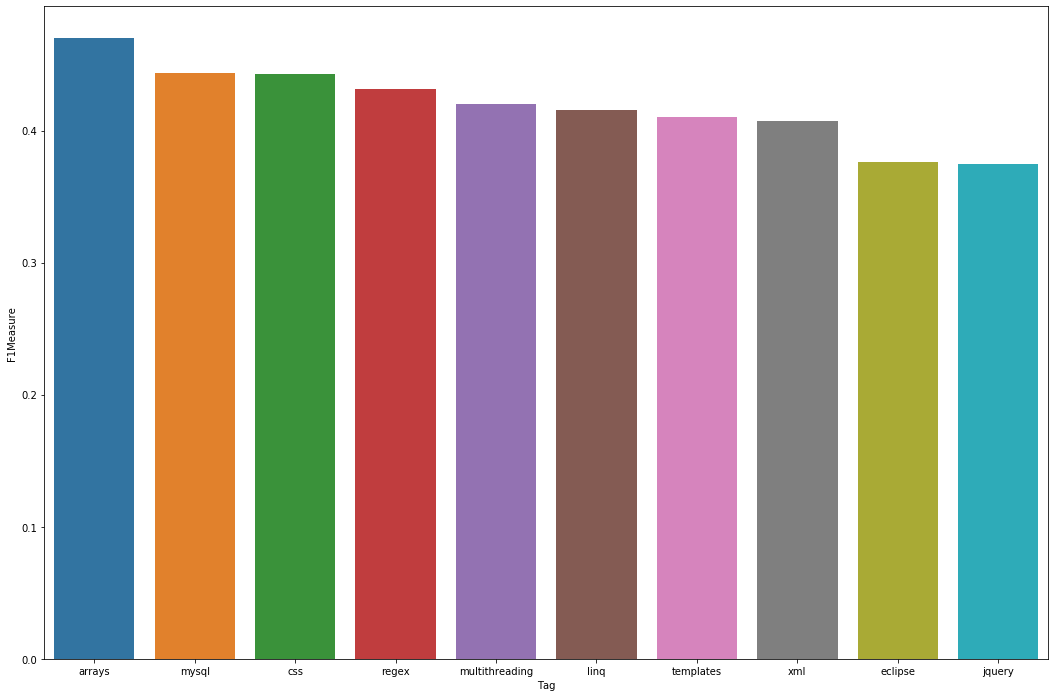

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="F1Measure", data=plot_df, ax=ax)
fig.show()

/Users/kailunzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


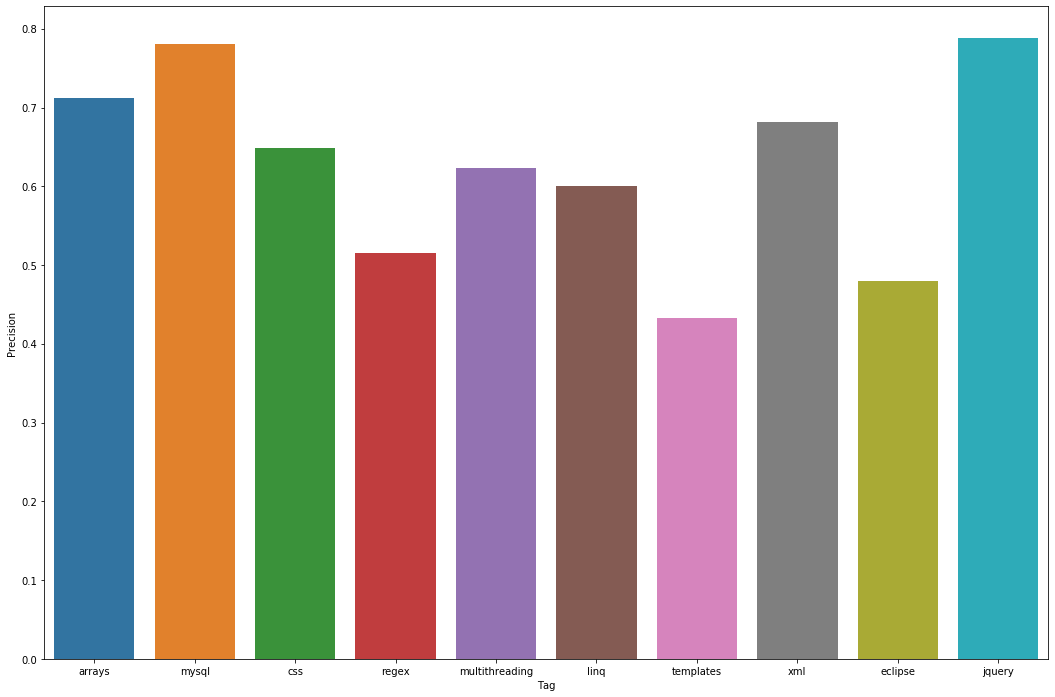

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="Precision", data=plot_df, ax=ax)
fig.show()

/Users/kailunzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


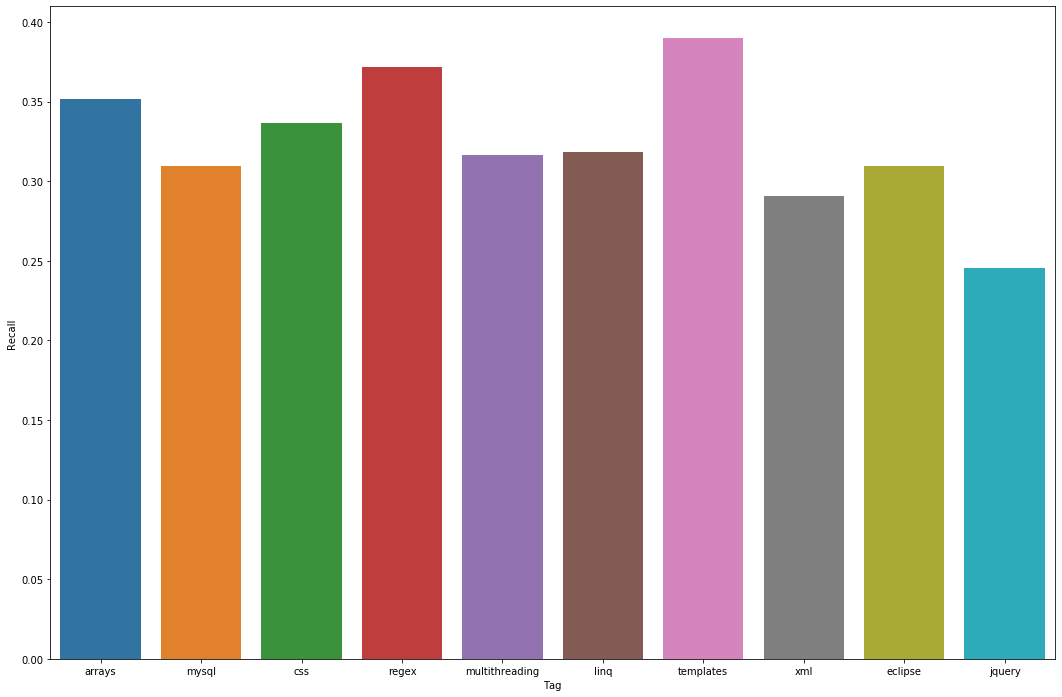

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="Recall", data=plot_df, ax=ax)
fig.show()

/Users/kailunzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


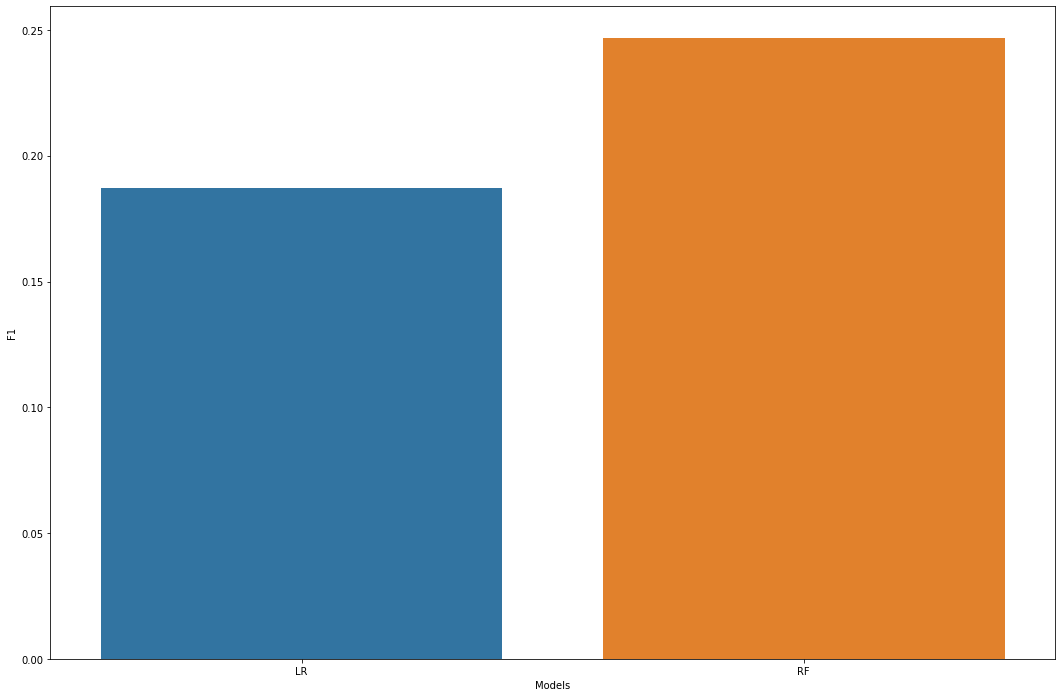

In [39]:

lr_trad = 0.187

rf_trad = 0.247
this_dict = {'Models': ["LR", "RF"], "F1": [lr_trad, rf_trad]}

seaborn_df = pd.DataFrame.from_dict(this_dict)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Models", y="F1", data=seaborn_df, ax =ax)
fig.show()